# Setup

In [ ]:
import numpy as np
import sklearn
import gensim
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# constants and global variables
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/CIL/Dataset/{}'
MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/CIL/Models/{}'

# if set to true the trainig of the classifier models will be performed, otherwise the 
# models will be loaded from a file (if present)
is_train_enabled = True

# Read Preprocessed Data

In [ ]:
def load_X_data(file_name):
  tweets = []
  with open(DATA_PATH.format(file_name), 'r', encoding='utf-8') as f:
      for line in f:
        tweets.append(line.rstrip().split())
  
  return np.array(tweets)

X_train = load_X_data("X_train_processed.txt")
X_test = load_X_data("X_test_processed.txt")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


In [ ]:
def load_y_data(file_name):
  labels = []
  with open(DATA_PATH.format(file_name), 'r', encoding='utf-8') as f:
      for line in f:
        labels.append(int(line.rstrip()))
  
  return np.array(labels)

y_train = load_y_data("y_train.txt")

In [ ]:
for i in range(10):
  print(X_train[i])
  print(X_test[i])
  print(y_train[i])

['yes', 'even', 'realize', 'really', 'wanted', 'respond', 'want', 'buy', 'candy', 'something']
['sea', 'doo', 'pro', 'sea', 'scooter', 'sport', 'portable', 'sea', 'doo', 'seascootersave', 'air']
1
['bradly', 'james', 'lowrey', 'bestfriend', 'mean', 'alot', 'justthoughtidleteveryoneknow']
['shuck', 'well', 'work', 'week', 'come', 'cheer', 'oh', 'put', 'battery', 'calculator']
1
['mckleinusa', 'ashburn', 'series', 'leather', 'laptop', 'case', 'brown', 'clean', 'front', 'flap', 'design', 'secure', 'key', 'l']
['cant', 'stay', 'away', 'bug', 'thats', 'baby']
0
['next', 'time', 'ima', 'come', 'yo', 'class', 'nd', 'wake', 'wanted', 'come', 'get', 'hug', 'sleep']
['lol', 'im', 'perfectly', 'fine', 'contagious', 'anymore', 'lmao']
0
['trivial', 'pursuit', 'junior', 'second', 'edition', 'second', 'edition', 'junior', 'legendary', 'trivial', 'pursuit', 'game']
['whenever', 'fall', 'asleep', 'watching', 'tv']
0
['new', 'bbm', 'add', 'please', 'pin']
['need', 'get', 'rid', 'thing', 'scare', 'lol',

# TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# join each tweet back into a single string
X_train = list(map(lambda tweet : " ".join(tweet), X_train))
X_test = list(map(lambda tweet : " ".join(tweet), X_test))

# this function is to prevent the TfidfVectorizer to perfrom its own preprocessing
def dummy_fun(doc):
    return doc

# define the model
tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None,
    ngram_range=(1,2),
    max_df=0.5,
    min_df=100)

# Fit the tfidf model
tfidf.fit(X_train)

feature_names = tfidf.get_feature_names_out()
print("Number of features: {}".format(len(tfidf.idf_)))

X_train = tfidf.transform(X_train)
X_test = tfidf.transform(X_test)

print("X_train shape is {}".format(X_train.shape))
print("X_test shape is {}".format(X_test.shape))

Number of features: 1153
X_train shape is (2500000, 1153)
X_test shape is (10000, 1153)


## Models
Apply standard machine learning models to the words embeddings that come out of TF-IDF.

In [ ]:
from sklearn.model_selection import train_test_split

# split the model into training test and validation
X_train, X_test_tmp, y_train, y_test_tmp = train_test_split(X_train, y_train, test_size=0.20, random_state=33)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.12, random_state=33)

### SVM

In [ ]:
from sklearn.svm import LinearSVC
# define model
model = LinearSVC(penalty='l1', dual=False, class_weight='balanced', fit_intercept=True,
                random_state=65, tol=1e-5)

In [ ]:
from joblib import dump, load

# train model
if is_train_enabled:
  model.fit(X_train, y_train)
  dump(model, MODEL_PATH.format('svc_tf_idf.joblib')) 

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [ ]:
# load the trained model from file
model = load(MODEL_PATH.format('svc_tf_idf.joblib')) 

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

# Plotting scores
y_pred = model.predict(X_test_tmp)

f1 = f1_score(y_test_tmp, y_pred, average="macro")
print("Test f1 score : %s "% f1)

acc = accuracy_score(y_test_tmp, y_pred)
print("Test accuracy score : %s "% acc)

Test f1 score : 0.7095736635171892 
Test accuracy score : 0.709598 


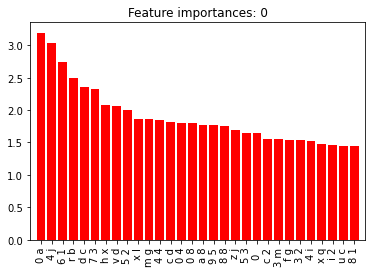

In [ ]:
# Function to plot feature importance
def plot_feature_importance(feature_imp, feature_name, N=30):
  
  indices = np.flip(np.argsort(np.absolute(feature_imp)))

  plt.figure()
  plt.rcParams['figure.figsize'] = [10, 6]
  plt.title("Feature importances: {}".format(feature_name))
  plt.bar(range(N), np.absolute(feature_imp[indices[:N]]),
          color="r", align="center")
  plt.xticks(range(N), feature_names[indices], rotation=90)
  plt.xlim([-1, N])
  plt.show()

  print('\n')


for i, c in enumerate(model.coef_):
    plot_feature_importance(c, i)

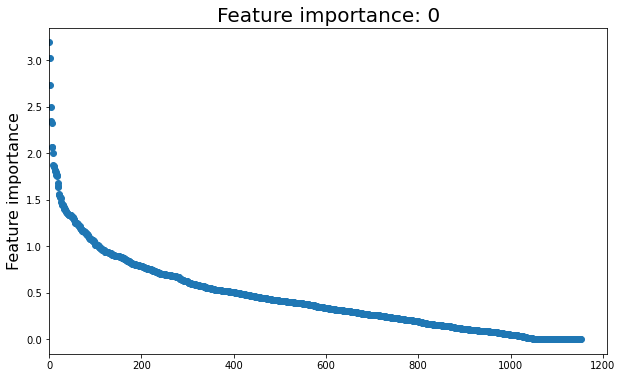

In [ ]:
def plot_importances(feature_imp, label):
  
  features = np.flip(np.sort(np.absolute(feature_imp)))
  plt.figure(figsize = (10,6))
  plt.scatter(x = range(features.shape[0]), y = features)
  plt.xlim(left = 0)
  plt.ylabel("Feature importance", size = 16)
  plt.title("Feature importance: {}".format(label), size = 20)
  plt.show()
  print('\n')

for i, c in enumerate(model.coef_):
    plot_importances(c, i)

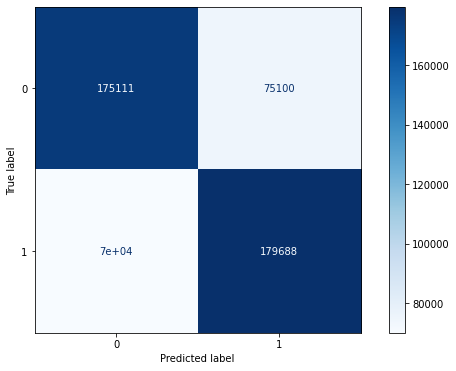

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot confusion matrix
cm = confusion_matrix(y_test_tmp, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])

disp.plot(cmap=plt.cm.Blues)
plt.show()